In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from collections import Counter
import seaborn as sns
import plotly.express as px
import typing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import umap
import numpy as np
from collections import defaultdict
from itertools import permutations
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman
import itertools
from networkx import edge_betweenness_centrality as betweenness
from networkx.algorithms.centrality import betweenness_centrality
from networkx.algorithms.link_analysis.pagerank_alg import pagerank
from networkx.algorithms.shortest_paths.generic import shortest_path_length, has_path, shortest_path
from networkx.algorithms.shortest_paths.weighted import all_pairs_dijkstra_path_length
from networkx.generators.ego import ego_graph
from sklearn.metrics import pairwise_distances

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
df_features = pd.read_csv('/content/drive/MyDrive/MLBD/data/spotify_features_cleaned.csv', index_col='Unnamed: 0')
df_features = df_features.dropna().reset_index(drop=True)
df_features.loc[:,'genres'] = df_features['genres'].apply(lambda x: x.strip("][").replace("'","").split(", "))

In [5]:
df_features

,artist,track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity
0,坂本龍一,Composition 0919 (Live_2009_4_15),0.806,0.413,5.0,-12.883,1.0,0.1560,0.987,0.794000,0.1130,0.5290,105.089,330253.0,"[japanese soundtrack, japanese classical, anim...",62
1,坂本龍一,Hibari (Live_2009_4_15),0.604,0.283,9.0,-19.811,0.0,0.0583,0.996,0.916000,0.1140,0.2700,137.802,540133.0,"[japanese soundtrack, japanese classical, anim...",62
2,坂本龍一,To Stanford (Live_2009_4_15),0.453,0.163,5.0,-20.922,1.0,0.0519,0.990,0.939000,0.1010,0.0703,73.926,216853.0,"[japanese indie folk, japanese soundtrack, jap...",39
3,坂本龍一,Improvisation (Live_2009_4_15),0.217,0.012,5.0,-36.464,1.0,0.0376,0.991,0.859000,0.0866,0.0376,80.714,384707.0,"[japanese soundtrack, japanese classical, anim...",62
4,坂本龍一,Glacier (Live_2009_4_15),0.518,0.213,9.0,-28.790,0.0,0.2090,0.869,0.898000,0.1030,0.0920,104.191,580707.0,"[japanese soundtrack, japanese classical, anim...",62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967212,Burlap To Cashmere,Mansions,0.583,0.640,0.0,-7.256,1.0,0.0375,0.169,0.000002,0.1540,0.5230,92.976,238293.0,"[christian music, acoustic rock, deep christia...",30
967213,Vashti Bunyan,Find My Heart Again,0.425,0.153,7.0,-18.232,1.0,0.0405,0.987,0.000214,0.1130,0.5900,172.509,121480.0,"[british folk, new weird america, freak folk, ...",55
967214,Vetiver,No One Word (Us29D0600003),0.511,0.261,4.0,-15.861,1.0,0.0326,0.623,0.842000,0.1060,0.4300,126.318,373187.0,"[stomp and holler, indie folk, freak folk]",47
967215,Req,Dharmas,0.713,0.329,1.0,-15.611,1.0,0.5100,0.125,0.000002,0.0399,0.4980,106.309,308267.0,"[deep idm, trip hop]",12


## Create graph of the genres
We create a graph of the different genres assigned to the tracks. We create it by creating and edge between every genre that appears in the same song. We experienced that a log normalized weighted graph works best. Therefore, we defined the weight between every edge in the following way: $W(A,B)\ =\ (\log(\sum_{(A,B)\in S_i, \forall i} 1))^{-1}$ where $A$ and $B$ are two different genres and $S_i$ is the set of genres of a song $i$.

In [6]:
graph_dict_basis = defaultdict(int)
genres_appear = defaultdict(int)
single_genres_list = [] 
for key, row in df_features.iterrows():
    genres = row['genres']
    if (len(genres) == 1) & (genres[0] != ''):
      single_genres_list.append(genres[0])
    for pair in permutations(genres, 2):
        one, two = sorted(pair)
        genres_appear[one] += 1
        genres_appear[two] += 1
        graph_dict_basis[one, two] += 1

In [7]:
graph_list = []
for (a,b) in graph_dict_basis.keys():
  graph_list.append(a)
  graph_list.append(b)
graph_set = set(graph_list)

single_genres_set = set(single_genres_list)

not_in_graph_set = single_genres_set.difference(graph_set)

In [8]:
len(graph_set)

4534

In [9]:
print(f"There are {len(not_in_graph_set)} genres of songs that are not in the graph and can therefore not be mapped. We will loose those songs.")

There are 224 genres of songs that are not in the graph and can therefore not be mapped. We will loose those songs.


In [10]:
log_normalized_graph_dict = {}
for (one, two), item in graph_dict_basis.items():
    log_normalized_graph_dict[one, two] = 1/np.log(item)

In [11]:
def prep_gephi_graph(graph_dict, fileName):
    "For some graph exploration with Gephi, we outputed the graph in a certain csv format"
    genres_graph = pd.DataFrame.from_dict(graph_dict, orient='index').reset_index()
    genres_graph[['Source', 'Target']] = genres_graph['index'].tolist()
    genres_graph = genres_graph.drop(columns='index').rename(columns={0:'weight'})
    genres_graph.to_csv(f'umap_results/{fileName}', index=False)
    
def prep_nx_graph(graph_dict):
    """Prepare the Graph with the networkx library from the dictionary we created"""
    genres_graph = pd.DataFrame.from_dict(graph_dict, orient='index').reset_index()
    genres_graph[['source', 'target']] = genres_graph['index'].tolist()
    genres_graph = genres_graph.drop(columns='index').rename(columns={0:'weight'})
    G = nx.from_pandas_edgelist(genres_graph, 'source', 'target', 'weight')
    return G

In [12]:
G_log = prep_nx_graph(log_normalized_graph_dict)

In [ ]:
centrality_G_log = betweenness_centrality(G_log, weight='weight')

In [ ]:
centrality_list = [[c[0],c[1]] for c in centrality_G_log.items()]

In [ ]:
centrality_df = pd.DataFrame(centrality_list, columns=['genre', 'G_log']).set_index('genre')

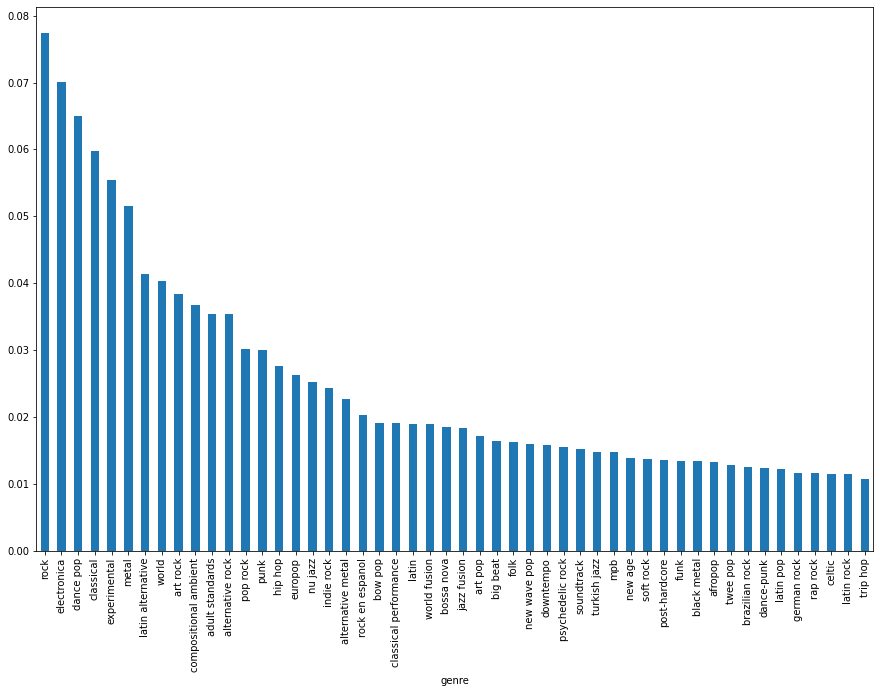

In [ ]:
centrality_df['G_log'].sort_values(ascending=False).head(50).plot.bar(figsize=(15,10))
plt.show()

In [13]:
def create_genres_mapping(super_genres, G):
    genres_mapping = {}
    for i, source in enumerate(G.nodes):
        genre = ''
        min_path_length = np.inf
        for super_g in super_genres:
            if has_path(G, source=source, target=super_g):
                sh_path = shortest_path_length(G, source=source, target=super_g, weight='weight')
            if sh_path < min_path_length:
                genre = super_g
                min_path_length = sh_path
        genres_mapping[source] = genre
    return genres_mapping
    
super_genres = ['pop', 'rock', 'electronica', 'hip hop', 'classical', 'jazz', 'folk', 'metal', 'experimental']
genres_mapping_norm = create_genres_mapping(super_genres, G_log)

In [14]:
all_shortest_paths_log = dict(all_pairs_dijkstra_path_length(G_log, cutoff=None, weight='weight'))

In [15]:
def create_distance_matrix(all_shortest_paths):
    mapping = {}
    inverse_mapping = {}
    for i, (key, item) in enumerate(sorted(all_shortest_paths.items())):
        mapping[key] = i
        inverse_mapping[i] = key
        
    length = len(list(set(all_shortest_paths.keys())))
    distance_matrix = np.full((length, length), np.inf)
    max_value = 0
    for key1, item1 in all_shortest_paths.items():
        for key2, item2 in item1.items():
            distance_matrix[mapping[key1], mapping[key2]] = item2
            if item2 > max_value:
                max_value = item2
    distance_matrix = np.where(distance_matrix==np.inf, max_value*10, distance_matrix) 
    return distance_matrix, mapping, inverse_mapping

In [16]:
dm_log, mapping_log, inverse_mapping_log = create_distance_matrix(all_shortest_paths_log)

In [17]:
fit = umap.UMAP(metric='precomputed')
u_log = fit.fit_transform(dm_log)

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning:

using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data



In [18]:
genre_names = np.expand_dims(np.array(sorted(all_shortest_paths_log.keys())), axis=1)
df_umap = pd.DataFrame(np.concatenate((genre_names, u_log), axis=1) , columns=['genre', 'emb1', 'emb2'])
for col in ['emb1', 'emb2']:
    df_umap[col] = pd.to_numeric(df_umap[col])
    
df_umap['supergenre'] = df_umap['genre'].map(genres_mapping_norm)

In [2]:
df_umap = pd.read_csv('umap.csv')

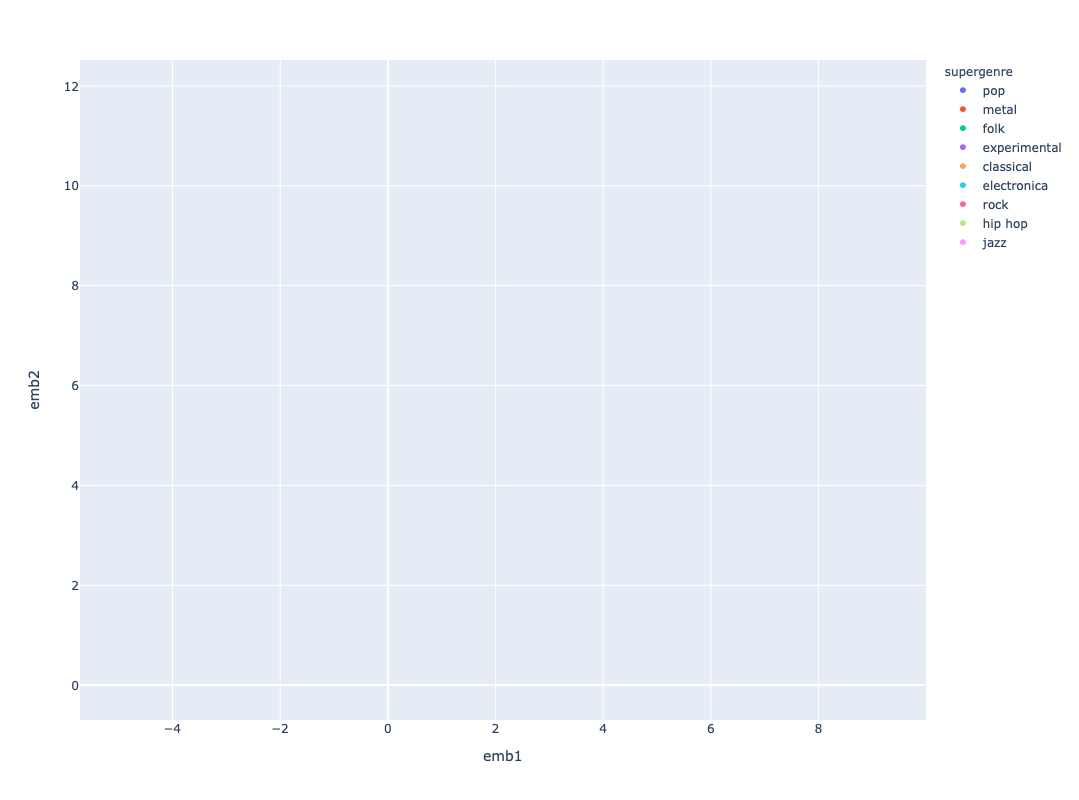

In [6]:
fig = px.scatter(df_umap, x='emb1', y='emb2', hover_data=['genre'], color='supergenre', width=1000, height=800)
fig.update_traces(marker=dict(size=6),
                  selector=dict(mode='markers'))
fig.show()
fig.write_html('umap_results/genres_map.html')
fig.write_image('umap_results/genres_map.pdf')

In [ ]:
fit = umap.UMAP(metric='precomputed', n_components=3)
u_log_3_dim = fit.fit_transform(dm_log)

In [ ]:
genre_names = np.expand_dims(np.array(sorted(all_shortest_paths_log.keys())), axis=1)
df_umap_3d = pd.DataFrame(np.concatenate((genre_names, u_log_3_dim), axis=1) , columns=['genre', 'emb1', 'emb2', 'emb3'])
for col in ['emb1', 'emb2', 'emb3']:
    df_umap_3d[col] = pd.to_numeric(df_umap_3d[col])
    
df_umap_3d['supergenre'] = df_umap_3d['genre'].map(genres_mapping_norm)

In [ ]:
fig_3d = px.scatter_3d(
    df_umap_3d, x='emb1', y='emb2', z='emb3',
    color='supergenre', labels={'color': 'supergenre'},
    
)
fig_3d.update_traces(marker_size=3)
fig_3d.show(renderer="colab")

In [ ]:
genres_emb = {}
for index, row in df_umap_3d.iterrows():
    genres_emb[row['genre']] = (row['emb1'], row['emb2'], row['emb3'])

In [ ]:
import json
with open('../data/genres_3d_mapping.json', 'w') as f:
    json.dump(genres_emb, f)

In [ ]:
import json
with open('/content/drive/MyDrive/MLBD/data/genres_3d_mapping.json') as f:
  genres_emb = json.load(f)

In [ ]:
def genres2embedding(genres):
    def extract_embeddings(genres):
        embeddings = []
        for genre in genres:
            if genre in genres_emb:
                emb = genres_emb[genre]
                embeddings.append(emb)
            else:
                print(f'{genre} is not in our embedding')
        return np.array(embeddings)
    if len(genres) > 1:
        embeddings = extract_embeddings(genres)
        dist = pairwise_distances(embeddings)
        dist[dist == 0] = np.inf
        ind1, ind2 = np.unravel_index(np.argmin(dist), dist.shape)
        return np.mean(embeddings[(ind1, ind2), :], axis=0)
    elif (len(genres) == 1) & (genres[0] != ''):
        if genres[0] in genres_emb:
            return genres_emb[genres[0]]
        else:
            print(f'{genres[0]} is not in among the embeddings.')
    else:
        return None

In [ ]:
df_features['genres_emb'] = df_features['genres'].apply(lambda x: genres2embedding(x))

In [ ]:
array_exploded = [np.array([None, None, None]) if row is None else row for row in df_features['genres_emb'].to_list()]
df_features[['emb_x', 'emb_y', 'emb_z']] = pd.DataFrame(array_exploded)

In [ ]:
df_features.to_csv('../data/feature_df_with_emb.csv')

In [ ]:
df_features.to_csv('/content/drive/MyDrive/MLBD/data/feature_df_with_emb_clean.csv')

In [ ]:
df_features = pd.read_csv('../data/feature_df_with_emb.csv', index_col='Unnamed: 0')

In [ ]:
df_features = pd.read_csv('/content/drive/MyDrive/MLBD/data/feature_df_with_emb_clean.csv', index_col='Unnamed: 0')

In [ ]:
df_features.iloc[[5331, 6930]]['genres'].iloc[1]

"['rock', 'funk metal', 'funk rock', 'alternative rock', 'permanent wave']"

## Create an embedding of the genres

In [ ]:
umap_features = df_features[['danceability',
                             'energy',
                             'speechiness', 
                             'acousticness', 
                             'instrumentalness', 
                             'liveness',
                             'valence', 
                             'tempo', 
                             'popularity', 
                             'emb_x', 
                             'emb_y',
                             'emb_z']]

In [ ]:
umap_features = umap_features.dropna()

In [ ]:
numerical_columns = umap_features.select_dtypes(include=['float','int']).columns
umap_features[numerical_columns] = MinMaxScaler().fit_transform(umap_features[numerical_columns].values)

In [ ]:
umap_features_fit = umap_features.iloc[np.random.choice(len(umap_features), 600000, replace=False)]

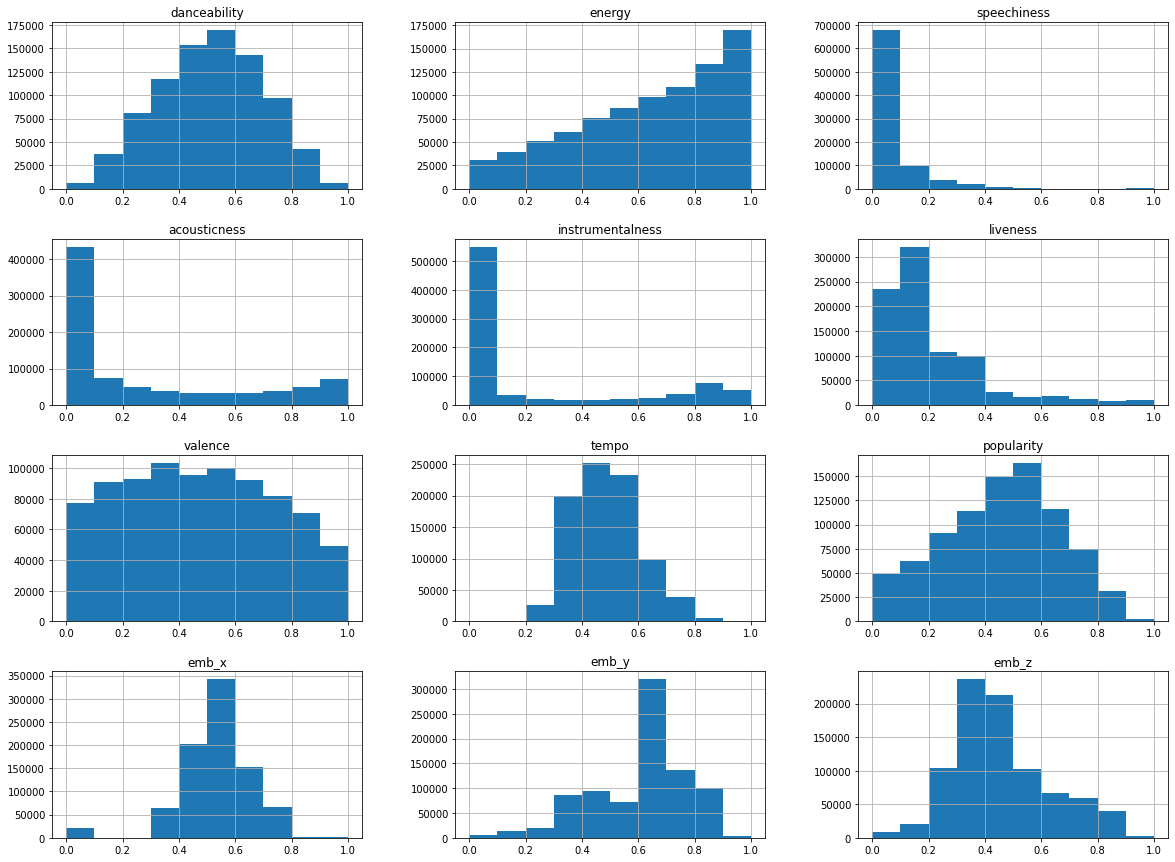

In [ ]:
umap_features.hist(figsize=(20,15))
plt.show()

In [ ]:
reducer = umap.UMAP(metric='correlation', low_memory=True)
model = reducer.fit(umap_features_fit.values)

In [ ]:
song_map = model.transform(umap_features)

In [ ]:
umap_features[['song_emb_x', 'song_emb_y']] = song_map

In [ ]:
song_map = umap_features[['song_emb_x', 'song_emb_y']].merge(df_features, left_index=True, right_index=True)

In [ ]:
song_map

In [ ]:
df_songs = pd.read_csv('/content/drive/MyDrive/MLBD/data/spotify_uris.csv')
df_songs

In [ ]:
df_songs['track + artist'] = df_songs['track'] + df_songs['artist']
song_map['track + artist'] = song_map['track'] + song_map['artist']
song_map = song_map.merge(df_songs[['track_id', 'album_id', 'track + artist']], how='left', left_on='track + artist', right_on='track + artist')

In [ ]:
song_map

In [ ]:
song_map.drop(columns='track + artist').to_csv('/content/drive/MyDrive/MLBD/data/song_map_corr.csv')

In [ ]:
song_map['supergenre'] = song_map['genre'].map(genres_mapping_norm)

In [ ]:
song_map

,song_emb_x,song_emb_y,artist,track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,genres_emb,emb_x,emb_y,emb_z
0,1.902900,-2.337135,坂本龍一,Composition 0919 (Live_2009_4_15),0.806,0.413,5.0,-12.883,1.0,0.1560,0.98700,0.794000,0.1130,0.5290,105.089,330253.0,"[japanese soundtrack, japanese classical, anim...",62,"[7.375276599999999, 4.8944925, 0.9434927099999...",7.375277,4.894493,0.943493
1,3.213105,10.087118,坂本龍一,Hibari (Live_2009_4_15),0.604,0.283,9.0,-19.811,0.0,0.0583,0.99600,0.916000,0.1140,0.2700,137.802,540133.0,"[japanese soundtrack, japanese classical, anim...",62,"[7.375276599999999, 4.8944925, 0.9434927099999...",7.375277,4.894493,0.943493
2,3.130475,10.416649,坂本龍一,To Stanford (Live_2009_4_15),0.453,0.163,5.0,-20.922,1.0,0.0519,0.99000,0.939000,0.1010,0.0703,73.926,216853.0,"[japanese indie folk, japanese soundtrack, jap...",39,"[7.375276599999999, 4.8944925, 0.9434927099999...",7.375277,4.894493,0.943493
3,3.186497,10.799794,坂本龍一,Improvisation (Live_2009_4_15),0.217,0.012,5.0,-36.464,1.0,0.0376,0.99100,0.859000,0.0866,0.0376,80.714,384707.0,"[japanese soundtrack, japanese classical, anim...",62,"[7.375276599999999, 4.8944925, 0.9434927099999...",7.375277,4.894493,0.943493
4,3.154623,10.302559,坂本龍一,Glacier (Live_2009_4_15),0.518,0.213,9.0,-28.790,0.0,0.2090,0.86900,0.898000,0.1030,0.0920,104.191,580707.0,"[japanese soundtrack, japanese classical, anim...",62,"[7.375276599999999, 4.8944925, 0.9434927099999...",7.375277,4.894493,0.943493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662599,6.720860,11.313569,Ace Of Base,Whenever You'Re Near Me (Strobe'S Radio Remix),0.626,0.863,0.0,-4.625,1.0,0.0362,0.08620,0.000841,0.0793,0.6360,97.067,211453.0,"[dance pop, eurodance, europop, bubblegum danc...",68,"[6.1338348, 6.96552385, 3.72065555]",6.133835,6.965524,3.720656
662601,11.325897,-3.707465,Ultrabeat,Better Than Life (Radio Edit),0.535,0.988,10.0,-9.423,0.0,0.0690,0.00486,0.000295,0.3770,0.5620,142.074,192013.0,"[eurodance, hardcore techno, bouncy house]",54,"[5.460743, 5.192393, 4.009093999999999]",5.460743,5.192393,4.009094
662602,17.894558,-0.056764,O-Zone,Dragostea Din Tei (Dj Aligator Vs. Js Jay Edit),0.812,0.968,0.0,-3.758,1.0,0.0421,0.16100,0.000000,0.0661,0.7060,130.093,213920.0,"[moldovan pop, europop, bubblegum dance, eurod...",62,"[6.1338348, 6.96552385, 3.72065555]",6.133835,6.965524,3.720656
662603,17.894527,-0.056764,O-Zone,Dragostea Din Teï (Dj Ross Radio Edit),0.812,0.968,0.0,-3.758,1.0,0.0421,0.16100,0.000000,0.0661,0.7060,130.093,213920.0,"[moldovan pop, europop, bubblegum dance, eurod...",62,"[6.1338348, 6.96552385, 3.72065555]",6.133835,6.965524,3.720656


In [ ]:
fig = px.scatter(song_map.iloc[:100000], x='song_emb_x', y='song_emb_y', hover_data=['genres', 'track', 'artist'], color='valence', width=1000, height=800)
fig.show(renderer="colab")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df = pd.concat([df_features.iloc[:len(embedding)], pd.DataFrame(embedding, columns=['emb_x', 'emb_y'])], axis=1)


In [ ]:
for feature in tqdm(df.columns[df.dtypes=='float64']):
    fig = px.scatter(df, x='emb_x', y='emb_y', hover_data=['genres', 'artist', 'track'], color=feature)
    fig.write_html(f'{feature}.html')